In [12]:
from align import *
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# Read reference image
refFilename = "form.jpg"
print("Reading reference image : ", refFilename)
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

print("Aligning images ...")
# Registered image will be resotred in imReg. 
# The estimated homography will be stored in h. 
imReg, h = alignImages(im, imReference)

# Print estimated homography
print("Estimated homography : \n",  h)
  

Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg
Aligning images ...
Estimated homography : 
 [[ 1.39410158e+00 -2.00799432e-01 -8.38501433e+00]
 [ 2.21486061e-01  1.51141269e+00 -4.78696622e+02]
 [-6.63760728e-05  1.17767381e-04  1.00000000e+00]]


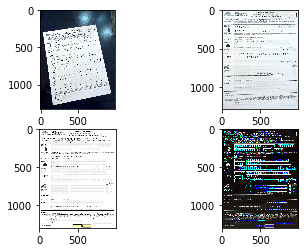

In [22]:
_, axes = plt.subplots(2,2)
axes[0,0].imshow(im)
axes[1,0].imshow(imReference)
axes[0,1].imshow(imReg)
axes[1,1].imshow(np.abs(imReference-imReg))

In [7]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import cv2
import math
import numpy as np
from PIL import Image, ImageDraw

In [52]:
def find_cor_points(img1, img2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # ORB, BF-Hamming 로 knnMatch  ---①
    detector = cv2.ORB_create()
    kp1, desc1 = detector.detectAndCompute(gray1, None)
    kp2, desc2 = detector.detectAndCompute(gray2, None)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desc1, desc2)

    # 매칭 결과를 거리기준 오름차순으로 정렬 ---③
    matches = sorted(matches, key=lambda x:x.distance)
    
    # 모든 매칭점 그리기 ---④
    res1 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # 매칭점으로 원근 변환 및 영역 표시 ---⑤
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    # RANSAC으로 변환 행렬 근사 계산 ---⑥
    mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h,w = img1.shape[:2]
    pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
    dst = cv2.perspectiveTransform(pts,mtrx)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    # 정상치 매칭만 그리기 ---⑦
    matchesMask = mask.ravel().tolist()
    res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                        matchesMask = matchesMask,
                        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    list_kp1_all = [kp1[mat.queryIdx].pt for mat, mask in zip(matches, matchesMask)] 
    list_kp2_all = [kp2[mat.trainIdx].pt for mat, mask in zip(matches, matchesMask)]

    list_kp1 = []
    list_kp2 = []
    for mat, msk in zip(matches, matchesMask) :
        if msk :
            list_kp1.append(kp1[mat.queryIdx].pt)
            list_kp2.append(kp2[mat.trainIdx].pt)

    # 모든 매칭점과 정상치 비율 ---⑧
    accuracy=float(mask.sum()) / mask.size * 100
    print("accuracy: %d/%d(%.2f%%)"% (mask.sum(), mask.size, accuracy))

    return list_kp1, list_kp2

img1 = 'data/source1.png'
img2 = 'data/target1.png'
p_in, p_ref = find_cor_points(img1, img2)

accuracy: 185/212(87.26%)


In [53]:
import cv2
import numpy as np

# Read 8-bit color image.
# This is an image in which the three channels are
# concatenated vertically.

def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)

    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad


im =  cv2.imread(img2, cv2.IMREAD_GRAYSCALE);

# Find the width and height of the color image
sz = im.shape
print(sz)
height = int(sz[0] / 3);
width = sz[1]

# Extract the three channels from the gray scale image
# and merge the three channels into one color image
im_color = np.zeros((height,width,3), dtype=np.uint8 )
for i in range(0,3) :
    im_color[:,:,i] = im[ i * height:(i+1) * height,:]

# Allocate space for aligned image
im_aligned = np.zeros((height,width,3), dtype=np.uint8 )

# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[:,:,2] = im_color[:,:,2]

# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY

# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

# Warp the blue and green channels to the red channel
for i in range(0,2) :
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im_color[:,:,2]), get_gradient(im_color[:,:,i]),warp_matrix, warp_mode, criteria)

if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use Perspective warp when the transformation is a Homography
    im_aligned[:,:,i] = cv2.warpPerspective (im_color[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
else :
    # Use Affine warp when the transformation is not a Homography
    im_aligned[:,:,i] = cv2.warpAffine(im_color[:,:,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    print(warp_matrix)

# Show final output
cv2.imshow("Color Image", im_color)
cv2.imshow("Aligned Image", im_aligned)
cv2.waitKey(0)


(840, 870)


error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\video\src\ecc.cpp:589: error: (-7:Iterations do not converge) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function 'cv::findTransformECC'


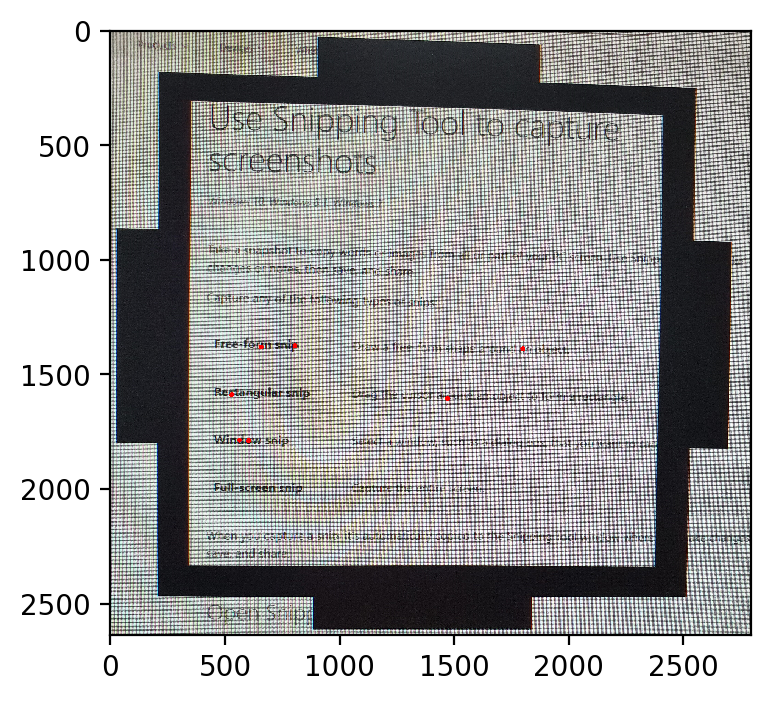

In [36]:
img_in = Image.open(img1).convert('RGB')

plt.figure(dpi=200)
r = 10
draw = ImageDraw.Draw(img_in)
for point in p_in:
    draw.ellipse((point[0]-r, point[1]-r, point[0]+r, point[1]+r), fill=(255,0,0,0))
imshow(img_in)

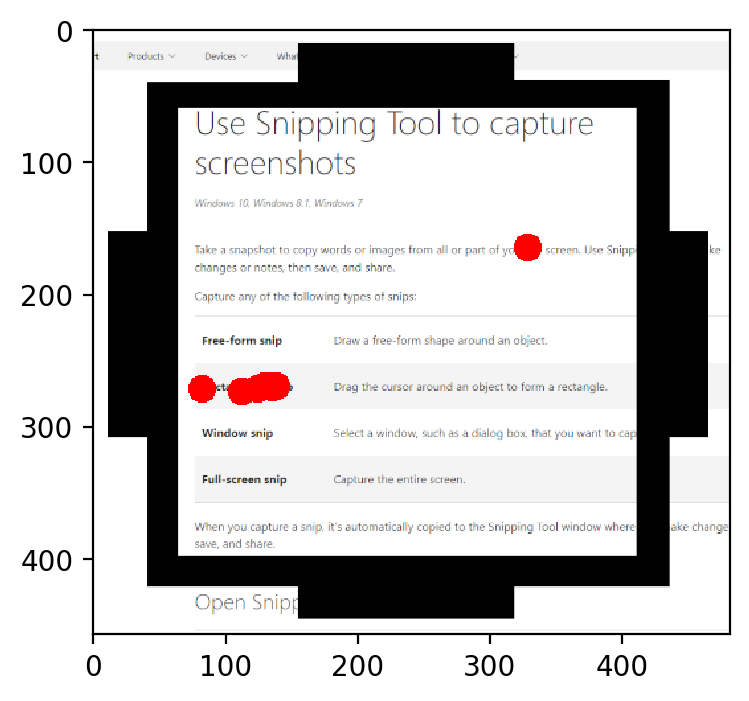

In [37]:
img_ref = Image.open(img2).convert('RGB')

plt.figure(dpi=200)
r = 10
draw = ImageDraw.Draw(img_ref)
for point in p_ref:
    draw.ellipse((point[0]-r, point[1]-r, point[0]+r, point[1]+r), fill=(255,0,0,0))
imshow(img_ref)

In [40]:
h, status = cv2.findHomography(np.asarray(p_in), np.asarray(p_ref))

In [2]:
import cv2
def compute_h(p1, p2):
    # SVD of A such that p1 = A p2
    assert(p1.shape == p2.shape)
    N = p1.shape[0]
    A = np.zeros((2*N, 9))
    for i in range(N):
        x1, y1 = p1[i]
        x2, y2 = p2[i]
        A[i*2:i*2+2,:] = np.array([[x2, y2, 1, 0, 0, 0, -x2*x1, -y2*x1, -x1],
                                   [0, 0, 0, x2, y2, 1, -x2*y1, -y2*y1, -y1]])

    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    return H

def compute_h_norm(p1, p2):
    # Nomalize H
    y_max, x_max = np.max([np.max(p1, axis=0), np.max(p2, axis=0)], axis=0)
    H = compute_h(p1 / (y_max, x_max), p2 / (y_max, x_max))
    
    H = H / np.sqrt(np.sum(H**2))
    H[0,:] *= y_max
    H[1,:] *= x_max
    H[:,0] /= y_max
    H[:,1] /= x_max
    
    return H / H[-1,-1]

In [3]:
def warp_image(igs_in, igs_ref, H):
    # Backward warping & merge images 
    height, width, _ = igs_in.shape   
    offset = height//2
    p_ref = []
    for x in range(-width, width):
        for y in range(2*height):
            point = [x, y-offset, 1]
            p_ref.append(point)
    p_ref = np.array(p_ref).transpose()
    
    H_inv = np.linalg.pinv(H)

    p_in = np.matmul(H_inv, p_ref)
    p_in = p_in / p_in[2, :]
    p_in = p_in[:2, :]
    p_in = np.round(p_in, 0).astype(np.int)

    igs_warp = np.zeros((height, width, 3), dtype = np.uint8)
    igs_merge = np.zeros((height*2, width*2, 3), dtype = np.uint8)
    for pt1, pt2 in zip(p_ref[:2, :].transpose(), p_in.transpose()):        
        if 0 <= pt2[1] < height and 0 <= pt2[0] < width:
            if 0 <= pt1[1] < height and 0 <= pt1[0] < width:
                igs_warp[pt1[1], pt1[0]] = igs_in[pt2[1], pt2[0]]
            igs_merge[pt1[1]+offset, pt1[0]+width] = igs_in[pt2[1], pt2[0]]
    igs_merge[offset:offset+height, width:width*2] = igs_ref
    
    return igs_warp, igs_merge

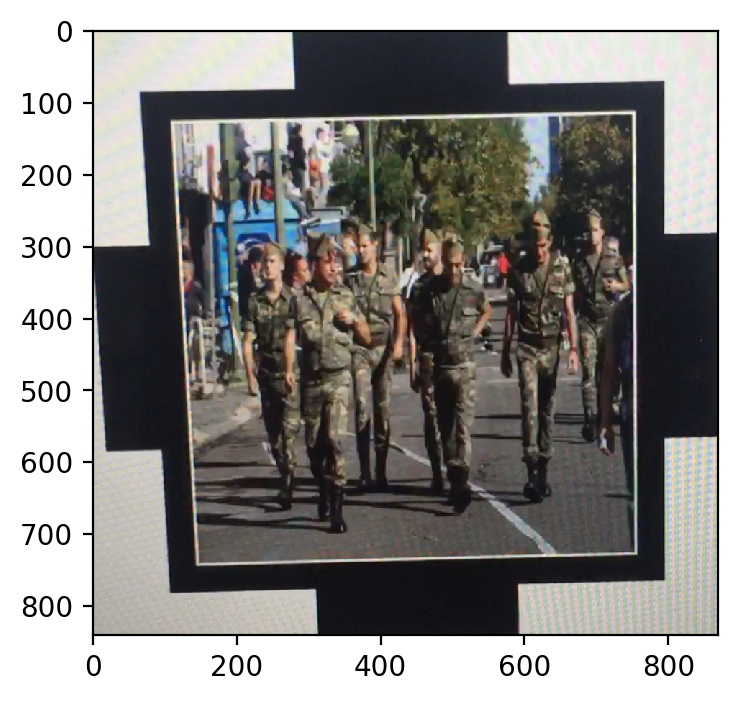

In [5]:
def set_cor_rec():
    # Set corresponding points for rectifying
    c_in = np.array([[1381, 163],
                    [1381, 831],
                    [1061, 820],
                    [1069, 194]])
    
    c_ref = np.array([[1200, 50],
                    [1200, 1000],
                    [700, 1000],
                    [700, 50]])
    
    return c_in, c_ref

##############
# step 2: rectification
##############

img_rec = Image.open('data/source.png').convert('RGB')
igs_rec = np.array(img_rec)

plt.figure(dpi=200)
igs_rec = Image.fromarray(igs_rec.astype(np.uint8))
imshow(igs_rec)

c_in, c_ref = set_cor_rec()

In [53]:
def rectify(igs, p1, p2):
    # Rectify
    H = compute_h_norm(p2, p1)
    igs_rec, _ = warp_image(igs, igs, H)

    return igs_rec

igs_rec = rectify(igs_rec, c_in, c_ref)

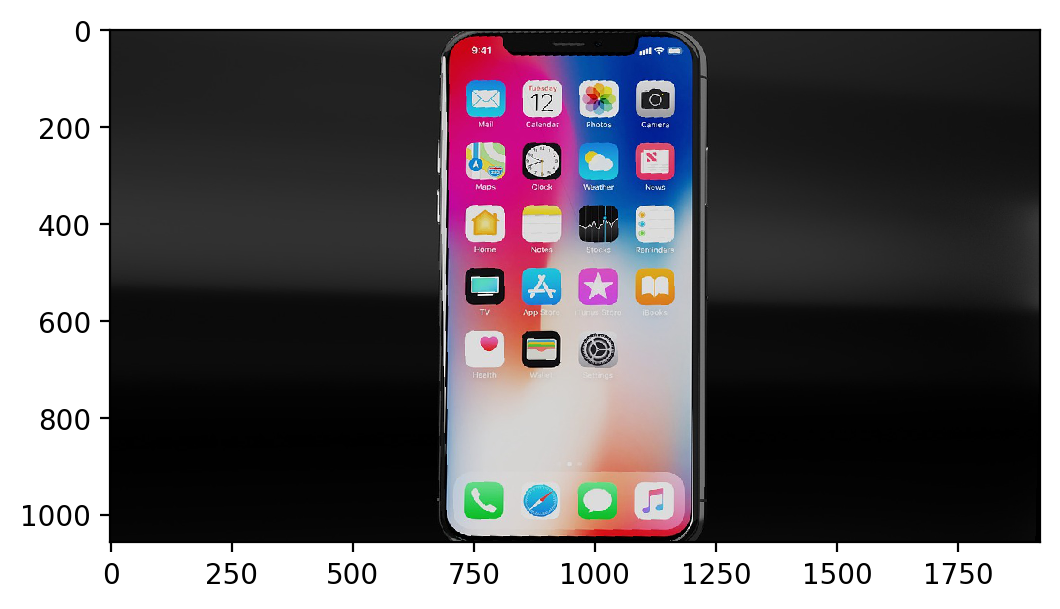

In [54]:
plt.figure(dpi=200)
igs_rec = Image.fromarray(igs_rec.astype(np.uint8))
imshow(igs_rec)